In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns


import utils

importlib.reload(utils)

<module 'utils' from '/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_02_00/utils.py'>

In [2]:
RANDOM_STATE = 2024
utils.seed_everything(RANDOM_STATE)

## データ読み込み

In [3]:
notebook_dir = Path().resolve()
DATA_DIR = notebook_dir.parents[3].joinpath("data")
DATASET_DIR = DATA_DIR.joinpath("atmaCup#18_dataset")
TR_FEATURES_CSV = DATASET_DIR.joinpath("train_features.csv")
TS_FEATURES_CSV = DATASET_DIR.joinpath("test_features.csv")
IMAGES_DIR = DATASET_DIR.joinpath("images")
TRAFFIC_LIGHTS_CSV = DATASET_DIR.joinpath("traffic_lights.csv")

IMAGE_NAMES = ["image_t.png", "image_t-0.5.png", "image_t-1.0.png"]

In [4]:
tr_df = utils.read_feature_csv(TR_FEATURES_CSV)
tr_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…","""320"""
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…","""420"""


In [5]:
ts_df = utils.read_feature_csv(TS_FEATURES_CSV)
ts_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,str
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…","""120"""
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…","""220"""


In [6]:
tr_images = utils.load_images(
    IMAGES_DIR, ids=tr_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(tr_images.shape)
ts_images = utils.load_images(
    IMAGES_DIR, ids=ts_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(ts_images.shape)

(43371, 3, 64, 128, 3)
(1727, 3, 64, 128, 3)


In [7]:
tr_images = utils.preprocess_images(tr_images)
ts_images = utils.preprocess_images(ts_images)

print(tr_images.shape)
print(ts_images.shape)

(43371, 9, 64, 128)
(1727, 9, 64, 128)


## Target

In [8]:
target = utils.CoordinateTarget(prefix="tg_")
target.fit(tr_df)

tg_df = target.transform(tr_df)
print(tg_df.columns)
print(tg_df.describe().glimpse())
tr_df = pl.concat([tr_df, tg_df], how="horizontal")

['tg_cood_x_0', 'tg_cood_y_0', 'tg_cood_z_0', 'tg_cood_x_1', 'tg_cood_y_1', 'tg_cood_z_1', 'tg_cood_x_2', 'tg_cood_y_2', 'tg_cood_z_2', 'tg_cood_x_3', 'tg_cood_y_3', 'tg_cood_z_3', 'tg_cood_x_4', 'tg_cood_y_4', 'tg_cood_z_4', 'tg_cood_x_5', 'tg_cood_y_5', 'tg_cood_z_5']
Rows: 9
Columns: 19
$ statistic   <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ tg_cood_x_0 <f64> 43371.0, 0.0, 4.122443942757371, 3.2667167639213908, -1.7321542071537557, 1.116530690565041, 3.843337458989432, 6.4281197924248215, 12.392587231992154
$ tg_cood_y_0 <f64> 43371.0, 0.0, 0.0019486856369589753, 0.11686590022408185, -2.5341378248203235, -0.02646308932096216, 0.0010884804706597444, 0.030664179622664968, 3.4595563267615925
$ tg_cood_z_0 <f64> 43371.0, 0.0, 0.001247332026343412, 0.040745039147660006, -0.9965478318668152, -0.017624552286421614, 0.0011112325970167394, 0.01959056385186172, 1.4479292511292303
$ tg_cood_x_1 <f64> 43371.0, 0.0, 8.694386412319787, 6.894354638218222, -3.1

## 特徴量

In [9]:
feature = utils.Feature(prefix="ft_")
feature.fit(tr_df)

ft_df = feature.transform(tr_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
tr_df = pl.concat([tr_df, ft_df], how="horizontal")

ft_df = feature.transform(ts_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
ts_df = pl.concat([ts_df, ft_df], how="horizontal")

['ft_vEgo', 'ft_aEgo', 'ft_steeringAngleDeg', 'ft_steeringTorque', 'ft_brake', 'ft_brakePressed', 'ft_gas', 'ft_gasPressed', 'ft_is_gearShifter_drive', 'ft_is_gearShifter_neutral', 'ft_is_gearShifter_park', 'ft_is_gearShifter_reverse', 'ft_leftBlinker', 'ft_rightBlinker']
Rows: 9
Columns: 15
$ statistic                 <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ ft_vEgo                   <f64> 43371.0, 0.0, 9.172175823216334, 7.226919878374694, -0.1619189828634262, 2.5786657333374023, 8.518790245056152, 14.286815643310547, 27.55126190185547
$ ft_aEgo                   <f64> 43371.0, 0.0, -0.015654028629347255, 0.6324016778486632, -4.936206340789795, -0.2363678514957428, -1.8347540436410405e-15, 0.22229795157909396, 3.1400704383850098
$ ft_steeringAngleDeg       <f64> 43371.0, 0.0, -2.065172574071012, 65.54882159006848, -481.394287109375, -3.461754322052002, -0.35647091269493103, 2.6269068717956543, 484.69171142578125
$ ft_steeringTorque         <f64>

## モデリング

In [10]:
N_SPLITS = 2

In [11]:
model_params = {
    "dnn": {
        "n_img_channels": 3 * 3,
        "n_features": len(feature.columns),
        "n_targets": len(target.columns),
        "segmentation_model_params": {
            "encoder_name": "resnet18",
            "encoder_weights": "imagenet",
            "decoder_channels": (256, 128, 64, 32, 16),
        },
        "n_bins": 100,
    },
    "dev": "cuda",
}

lr = 1e-4
fit_params = {
    "target_scaler": {
        "margin": 0.05,
    },
    "dnn": {
        "tr_batch_size": 128,
        "vl_batch_size": 128,
        "trainer_params": {
            "criterion_params": {"ref_bin_proba_sigma": 0.025, "dev": "cuda"},
            "opt": "adamw",
            "opt_params": {"lr": lr, "weight_decay": 1e-4},
            "backbone_opt_params": {"lr": lr, "weight_decay": 1e-4},
            "sch_params": {
                "max_lr": lr,
                "pct_start": 0.1,
                "div_factor": 25,
                "final_div_factor": 1000,
            },
            "epochs": 40,
            "dev": "cuda",
            "prefix": "",
            "save_best": False,
            "save_epochs": [],
            "maximize_score": False,
            "grad_max_norm": None,
        },
    },
}

In [12]:
models, oof_preds = utils.train(
    model_params=model_params,
    fit_params=fit_params,
    df=tr_df,
    images=tr_images,
    target_cols=target.columns,
    feature_cols=feature.columns,
    group_col="scene_id",
    n_splits=N_SPLITS,
)

-----------------
-----------------
Training fold 0...
train samples: 21685, valid samples: 21686
Save model : model.pth

epoch  0
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06


100%|██████████| 170/170 [00:03<00:00, 46.67it/s]



Train Loss: 4.6202
{'loss': 4.620208085641353, 'loss_bin_logit': 4.620208085641353}
Valid Loss: 4.6077
{'loss': 4.607689506867352, 'loss_bin_logit': 4.607689506867352}
Update best score : 4.607689506867352
Save model : model.pth

epoch  1
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05


100%|██████████| 170/170 [00:03<00:00, 49.11it/s]



Train Loss: 4.5866
{'loss': 4.586577265925661, 'loss_bin_logit': 4.586577265925661}
Valid Loss: 4.5499
{'loss': 4.549872392766616, 'loss_bin_logit': 4.549872392766616}
Update best score : 4.549872392766616
Save model : model.pth

epoch  2
lr  5.211170097130961e-05
lr  5.211170097130961e-05
lr  5.211170097130961e-05
lr  5.211170097130961e-05


100%|██████████| 170/170 [00:03<00:00, 49.86it/s]



Train Loss: 4.4796
{'loss': 4.479640201704036, 'loss_bin_logit': 4.479640201704036}
Valid Loss: 4.3847
{'loss': 4.384651952631334, 'loss_bin_logit': 4.384651952631334}
Update best score : 4.384651952631334
Save model : model.pth

epoch  3
lr  8.6059395353753e-05
lr  8.6059395353753e-05
lr  8.6059395353753e-05
lr  8.6059395353753e-05


100%|██████████| 170/170 [00:03<00:00, 49.89it/s]



Train Loss: 4.2740
{'loss': 4.273955187148596, 'loss_bin_logit': 4.273955187148596}
Valid Loss: 4.1487
{'loss': 4.148724668166217, 'loss_bin_logit': 4.148724668166217}
Update best score : 4.148724668166217
Save model : model.pth

epoch  4
lr  9.999999333432766e-05
lr  9.999999333432766e-05
lr  9.999999333432766e-05
lr  9.999999333432766e-05


100%|██████████| 170/170 [00:03<00:00, 49.65it/s]



Train Loss: 4.0404
{'loss': 4.0404426952790935, 'loss_bin_logit': 4.0404426952790935}
Valid Loss: 3.9310
{'loss': 3.931015591060414, 'loss_bin_logit': 3.931015591060414}
Update best score : 3.931015591060414
Save model : model.pth

epoch  5
lr  9.980748573618664e-05
lr  9.980748573618664e-05
lr  9.980748573618664e-05
lr  9.980748573618664e-05


100%|██████████| 170/170 [00:03<00:00, 49.87it/s]



Train Loss: 3.8276
{'loss': 3.8276105829949914, 'loss_bin_logit': 3.8276105829949914}
Valid Loss: 3.7277
{'loss': 3.7276726666618796, 'loss_bin_logit': 3.7276726666618796}
Update best score : 3.7276726666618796
Save model : model.pth

epoch  6
lr  9.92359283182187e-05
lr  9.92359283182187e-05
lr  9.92359283182187e-05
lr  9.92359283182187e-05


100%|██████████| 170/170 [00:03<00:00, 50.05it/s]



Train Loss: 3.6498
{'loss': 3.6497511144220476, 'loss_bin_logit': 3.6497511144220476}
Valid Loss: 3.5630
{'loss': 3.5630028640522675, 'loss_bin_logit': 3.5630028640522675}
Update best score : 3.5630028640522675
Save model : model.pth

epoch  7
lr  9.828967097749041e-05
lr  9.828967097749041e-05
lr  9.828967097749041e-05
lr  9.828967097749041e-05


100%|██████████| 170/170 [00:03<00:00, 49.89it/s]



Train Loss: 3.5012
{'loss': 3.501174857630532, 'loss_bin_logit': 3.501174857630532}
Valid Loss: 3.4226
{'loss': 3.422564948306364, 'loss_bin_logit': 3.422564948306364}
Update best score : 3.422564948306364
Save model : model.pth

epoch  8
lr  9.69759153037305e-05
lr  9.69759153037305e-05
lr  9.69759153037305e-05
lr  9.69759153037305e-05


100%|██████████| 170/170 [00:03<00:00, 49.68it/s]



Train Loss: 3.3793
{'loss': 3.379330361383201, 'loss_bin_logit': 3.379330361383201}
Valid Loss: 3.3214
{'loss': 3.32136853722965, 'loss_bin_logit': 3.32136853722965}
Update best score : 3.32136853722965
Save model : model.pth

epoch  9
lr  9.530465977088365e-05
lr  9.530465977088365e-05
lr  9.530465977088365e-05
lr  9.530465977088365e-05


100%|██████████| 170/170 [00:03<00:00, 49.87it/s]



Train Loss: 3.2786
{'loss': 3.2785860814991787, 'loss_bin_logit': 3.2785860814991787}
Valid Loss: 3.2321
{'loss': 3.2320775873520793, 'loss_bin_logit': 3.2320775873520793}
Update best score : 3.2320775873520793
Save model : model.pth

epoch  10
lr  9.32886236426865e-05
lr  9.32886236426865e-05
lr  9.32886236426865e-05
lr  9.32886236426865e-05


100%|██████████| 170/170 [00:03<00:00, 50.01it/s]



Train Loss: 3.1937
{'loss': 3.1937097021813927, 'loss_bin_logit': 3.1937097021813927}
Valid Loss: 3.1447
{'loss': 3.1447271865956923, 'loss_bin_logit': 3.1447271865956923}
Update best score : 3.1447271865956923
Save model : model.pth

epoch  11
lr  9.094315017139055e-05
lr  9.094315017139055e-05
lr  9.094315017139055e-05
lr  9.094315017139055e-05


100%|██████████| 170/170 [00:03<00:00, 49.77it/s]



Train Loss: 3.1245
{'loss': 3.124527172224056, 'loss_bin_logit': 3.124527172224056}
Valid Loss: 3.0935
{'loss': 3.0934594799490536, 'loss_bin_logit': 3.0934594799490536}
Update best score : 3.0934594799490536
Save model : model.pth

epoch  12
lr  8.828608982634794e-05
lr  8.828608982634794e-05
lr  8.828608982634794e-05
lr  8.828608982634794e-05


100%|██████████| 170/170 [00:03<00:00, 49.95it/s]



Train Loss: 3.0690
{'loss': 3.068955690903071, 'loss_bin_logit': 3.068955690903071}
Valid Loss: 3.0369
{'loss': 3.0368865055196426, 'loss_bin_logit': 3.0368865055196426}
Update best score : 3.0368865055196426
Save model : model.pth

epoch  13
lr  8.533766444116135e-05
lr  8.533766444116135e-05
lr  8.533766444116135e-05
lr  8.533766444116135e-05


100%|██████████| 170/170 [00:03<00:00, 49.97it/s]



Train Loss: 3.0221
{'loss': 3.022118380789221, 'loss_bin_logit': 3.022118380789221}
Valid Loss: 2.9980
{'loss': 2.9979512817719405, 'loss_bin_logit': 2.9979512817719405}
Update best score : 2.9979512817719405
Save model : model.pth

epoch  14
lr  8.212031331331998e-05
lr  8.212031331331998e-05
lr  8.212031331331998e-05
lr  8.212031331331998e-05


100%|██████████| 170/170 [00:03<00:00, 49.29it/s]



Train Loss: 2.9824
{'loss': 2.9824015134890405, 'loss_bin_logit': 2.9824015134890405}
Valid Loss: 2.9617
{'loss': 2.9616778023102706, 'loss_bin_logit': 2.9616778023102706}
Update best score : 2.9616778023102706
Save model : model.pth

epoch  15
lr  7.865852242759644e-05
lr  7.865852242759644e-05
lr  7.865852242759644e-05
lr  7.865852242759644e-05


100%|██████████| 170/170 [00:03<00:00, 49.92it/s]



Train Loss: 2.9493
{'loss': 2.949309274289735, 'loss_bin_logit': 2.949309274289735}
Valid Loss: 2.9278
{'loss': 2.9277531637864955, 'loss_bin_logit': 2.9277531637864955}
Update best score : 2.9277531637864955
Save model : model.pth

epoch  16
lr  7.497863810291755e-05
lr  7.497863810291755e-05
lr  7.497863810291755e-05
lr  7.497863810291755e-05


100%|██████████| 170/170 [00:03<00:00, 49.79it/s]



Train Loss: 2.9182
{'loss': 2.9182338277263753, 'loss_bin_logit': 2.9182338277263753}
Valid Loss: 2.9012
{'loss': 2.901165441905751, 'loss_bin_logit': 2.901165441905751}
Update best score : 2.901165441905751
Save model : model.pth

epoch  17
lr  7.110866648096904e-05
lr  7.110866648096904e-05
lr  7.110866648096904e-05
lr  7.110866648096904e-05


100%|██████████| 170/170 [00:03<00:00, 47.94it/s]



Train Loss: 2.8905
{'loss': 2.89046081706617, 'loss_bin_logit': 2.89046081706617}
Valid Loss: 2.8766
{'loss': 2.8766108050065884, 'loss_bin_logit': 2.8766108050065884}
Update best score : 2.8766108050065884
Save model : model.pth

epoch  18
lr  6.707806038254668e-05
lr  6.707806038254668e-05
lr  6.707806038254668e-05
lr  6.707806038254668e-05


100%|██████████| 170/170 [00:03<00:00, 48.27it/s]



Train Loss: 2.8674
{'loss': 2.8673741253170038, 'loss_bin_logit': 2.8673741253170038}
Valid Loss: 2.8592
{'loss': 2.8591860799228446, 'loss_bin_logit': 2.8591860799228446}
Update best score : 2.8591860799228446
Save model : model.pth

epoch  19
lr  6.291749515380597e-05
lr  6.291749515380597e-05
lr  6.291749515380597e-05
lr  6.291749515380597e-05


100%|██████████| 170/170 [00:03<00:00, 47.99it/s]



Train Loss: 2.8475
{'loss': 2.847546361607207, 'loss_bin_logit': 2.847546361607207}
Valid Loss: 2.8433
{'loss': 2.8433480234707105, 'loss_bin_logit': 2.8433480234707105}
Update best score : 2.8433480234707105
Save model : model.pth

epoch  20
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05


100%|██████████| 170/170 [00:03<00:00, 48.55it/s]



Train Loss: 2.8314
{'loss': 2.8314086586765987, 'loss_bin_logit': 2.8314086586765987}
Valid Loss: 2.8243
{'loss': 2.8242701292037964, 'loss_bin_logit': 2.8242701292037964}
Update best score : 2.8242701292037964
Save model : model.pth

epoch  21
lr  5.433389304195041e-05
lr  5.433389304195041e-05
lr  5.433389304195041e-05
lr  5.433389304195041e-05


100%|██████████| 170/170 [00:03<00:00, 48.40it/s]



Train Loss: 2.8160
{'loss': 2.816012467152974, 'loss_bin_logit': 2.816012467152974}
Valid Loss: 2.8133
{'loss': 2.8132573464337516, 'loss_bin_logit': 2.8132573464337516}
Update best score : 2.8132573464337516
Save model : model.pth

epoch  22
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05


100%|██████████| 170/170 [00:03<00:00, 48.59it/s]



Train Loss: 2.8019
{'loss': 2.801944052679299, 'loss_bin_logit': 2.801944052679299}
Valid Loss: 2.8019
{'loss': 2.801949704394621, 'loss_bin_logit': 2.801949704394621}
Update best score : 2.801949704394621
Save model : model.pth

epoch  23
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05


100%|██████████| 170/170 [00:03<00:00, 48.62it/s]



Train Loss: 2.7898
{'loss': 2.7897816974030443, 'loss_bin_logit': 2.7897816974030443}
Valid Loss: 2.7909
{'loss': 2.790888274417204, 'loss_bin_logit': 2.790888274417204}
Update best score : 2.790888274417204
Save model : model.pth

epoch  24
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05


100%|██████████| 170/170 [00:03<00:00, 48.35it/s]



Train Loss: 2.7795
{'loss': 2.779483865704057, 'loss_bin_logit': 2.779483865704057}
Valid Loss: 2.7822
{'loss': 2.7822436346727257, 'loss_bin_logit': 2.7822436346727257}
Update best score : 2.7822436346727257
Save model : model.pth

epoch  25
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05


100%|██████████| 170/170 [00:03<00:00, 48.50it/s]



Train Loss: 2.7700
{'loss': 2.7700460577857564, 'loss_bin_logit': 2.7700460577857564}
Valid Loss: 2.7743
{'loss': 2.774250726138844, 'loss_bin_logit': 2.774250726138844}
Update best score : 2.774250726138844
Save model : model.pth

epoch  26
lr  3.287741869014153e-05
lr  3.287741869014153e-05
lr  3.287741869014153e-05
lr  3.287741869014153e-05


100%|██████████| 170/170 [00:03<00:00, 48.55it/s]



Train Loss: 2.7626
{'loss': 2.7625589497696015, 'loss_bin_logit': 2.7625589497696015}
Valid Loss: 2.7689
{'loss': 2.7688581957536584, 'loss_bin_logit': 2.7688581957536584}
Update best score : 2.7688581957536584
Save model : model.pth

epoch  27
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05


100%|██████████| 170/170 [00:03<00:00, 48.67it/s]



Train Loss: 2.7560
{'loss': 2.7560027421578854, 'loss_bin_logit': 2.7560027421578854}
Valid Loss: 2.7623
{'loss': 2.7622696974698235, 'loss_bin_logit': 2.7622696974698235}
Update best score : 2.7622696974698235
Save model : model.pth

epoch  28
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05


100%|██████████| 170/170 [00:03<00:00, 48.09it/s]



Train Loss: 2.7498
{'loss': 2.749798441779684, 'loss_bin_logit': 2.749798441779684}
Valid Loss: 2.7586
{'loss': 2.7586284903918994, 'loss_bin_logit': 2.7586284903918994}
Update best score : 2.7586284903918994
Save model : model.pth

epoch  29
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05


100%|██████████| 170/170 [00:03<00:00, 48.69it/s]



Train Loss: 2.7454
{'loss': 2.7453554240909552, 'loss_bin_logit': 2.7453554240909552}
Valid Loss: 2.7550
{'loss': 2.7549577713012696, 'loss_bin_logit': 2.7549577713012696}
Update best score : 2.7549577713012696
Save model : model.pth

epoch  30
lr  1.784413206432799e-05
lr  1.784413206432799e-05
lr  1.784413206432799e-05
lr  1.784413206432799e-05


100%|██████████| 170/170 [00:03<00:00, 48.44it/s]



Train Loss: 2.7405
{'loss': 2.7405104735899255, 'loss_bin_logit': 2.7405104735899255}
Valid Loss: 2.7511
{'loss': 2.7510839840945076, 'loss_bin_logit': 2.7510839840945076}
Update best score : 2.7510839840945076
Save model : model.pth

epoch  31
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05


100%|██████████| 170/170 [00:03<00:00, 48.26it/s]



Train Loss: 2.7364
{'loss': 2.7363886466393104, 'loss_bin_logit': 2.7363886466393104}
Valid Loss: 2.7477
{'loss': 2.7476672761580523, 'loss_bin_logit': 2.7476672761580523}
Update best score : 2.7476672761580523
Save model : model.pth

epoch  32
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05


100%|██████████| 170/170 [00:03<00:00, 48.31it/s]



Train Loss: 2.7348
{'loss': 2.7348263969082804, 'loss_bin_logit': 2.7348263969082804}
Valid Loss: 2.7462
{'loss': 2.7461845678441663, 'loss_bin_logit': 2.7461845678441663}
Update best score : 2.7461845678441663
Save model : model.pth

epoch  33
lr  9.03123327106677e-06
lr  9.03123327106677e-06
lr  9.03123327106677e-06
lr  9.03123327106677e-06


100%|██████████| 170/170 [00:03<00:00, 48.58it/s]



Train Loss: 2.7326
{'loss': 2.7326042680345344, 'loss_bin_logit': 2.7326042680345344}
Valid Loss: 2.7446
{'loss': 2.7445916554507086, 'loss_bin_logit': 2.7445916554507086}
Update best score : 2.7445916554507086
Save model : model.pth

epoch  34
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06


100%|██████████| 170/170 [00:03<00:00, 48.01it/s]



Train Loss: 2.7308
{'loss': 2.730810951199052, 'loss_bin_logit': 2.730810951199052}
Valid Loss: 2.7439
{'loss': 2.743852132909438, 'loss_bin_logit': 2.743852132909438}
Update best score : 2.743852132909438
Save model : model.pth

epoch  35
lr  4.67751838066829e-06
lr  4.67751838066829e-06
lr  4.67751838066829e-06
lr  4.67751838066829e-06


100%|██████████| 170/170 [00:03<00:00, 48.31it/s]



Train Loss: 2.7285
{'loss': 2.7285457616727027, 'loss_bin_logit': 2.7285457616727027}
Valid Loss: 2.7424
{'loss': 2.7423731200835286, 'loss_bin_logit': 2.7423731200835286}
Update best score : 2.7423731200835286
Save model : model.pth

epoch  36
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06


100%|██████████| 170/170 [00:03<00:00, 48.04it/s]



Train Loss: 2.7285
{'loss': 2.728504869359485, 'loss_bin_logit': 2.728504869359485}
Valid Loss: 2.7429
{'loss': 2.7429263086879954, 'loss_bin_logit': 2.7429263086879954}
Save model : model.pth

epoch  37
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06


100%|██████████| 170/170 [00:03<00:00, 48.70it/s]



Train Loss: 2.7286
{'loss': 2.7286016165152103, 'loss_bin_logit': 2.7286016165152103}
Valid Loss: 2.7420
{'loss': 2.7420309291166416, 'loss_bin_logit': 2.7420309291166416}
Update best score : 2.7420309291166416
Save model : model.pth

epoch  38
lr  7.591053768215416e-07
lr  7.591053768215416e-07
lr  7.591053768215416e-07
lr  7.591053768215416e-07


100%|██████████| 170/170 [00:03<00:00, 49.12it/s]



Train Loss: 2.7281
{'loss': 2.728108984478832, 'loss_bin_logit': 2.728108984478832}
Valid Loss: 2.7426
{'loss': 2.742551998531117, 'loss_bin_logit': 2.742551998531117}
Save model : model.pth

epoch  39
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07


100%|██████████| 170/170 [00:03<00:00, 49.04it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_02_00/utils.py:1007: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 


Train Loss: 2.7274
{'loss': 2.7273661257952626, 'loss_bin_logit': 2.7273661257952626}
Valid Loss: 2.7425
{'loss': 2.742488469797022, 'loss_bin_logit': 2.742488469797022}
Save model : model.pth
-----------------
-----------------
Training fold 1...
train samples: 21686, valid samples: 21685
Save model : model.pth

epoch  0
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06


100%|██████████| 170/170 [00:03<00:00, 42.56it/s]



Train Loss: 4.6230
{'loss': 4.6229939545400045, 'loss_bin_logit': 4.6229939545400045}
Valid Loss: 4.6091
{'loss': 4.609100787779864, 'loss_bin_logit': 4.609100787779864}
Update best score : 4.609100787779864
Save model : model.pth

epoch  1
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05


100%|██████████| 170/170 [00:03<00:00, 48.72it/s]



Train Loss: 4.5890
{'loss': 4.588984622052435, 'loss_bin_logit': 4.588984622052435}
Valid Loss: 4.5582
{'loss': 4.558213733224308, 'loss_bin_logit': 4.558213733224308}
Update best score : 4.558213733224308
Save model : model.pth

epoch  2
lr  5.211170097130961e-05
lr  5.211170097130961e-05
lr  5.211170097130961e-05
lr  5.211170097130961e-05


100%|██████████| 170/170 [00:03<00:00, 48.29it/s]



Train Loss: 4.4935
{'loss': 4.493451174899671, 'loss_bin_logit': 4.493451174899671}
Valid Loss: 4.4044
{'loss': 4.404409531986012, 'loss_bin_logit': 4.404409531986012}
Update best score : 4.404409531986012
Save model : model.pth

epoch  3
lr  8.6059395353753e-05
lr  8.6059395353753e-05
lr  8.6059395353753e-05
lr  8.6059395353753e-05


100%|██████████| 170/170 [00:03<00:00, 48.32it/s]



Train Loss: 4.2784
{'loss': 4.278350192414233, 'loss_bin_logit': 4.278350192414233}
Valid Loss: 4.1503
{'loss': 4.150280576593736, 'loss_bin_logit': 4.150280576593736}
Update best score : 4.150280576593736
Save model : model.pth

epoch  4
lr  9.999999333432766e-05
lr  9.999999333432766e-05
lr  9.999999333432766e-05
lr  9.999999333432766e-05


100%|██████████| 170/170 [00:03<00:00, 48.27it/s]



Train Loss: 4.0295
{'loss': 4.029450237398317, 'loss_bin_logit': 4.029450237398317}
Valid Loss: 3.9077
{'loss': 3.907675601454342, 'loss_bin_logit': 3.907675601454342}
Update best score : 3.907675601454342
Save model : model.pth

epoch  5
lr  9.980748573618664e-05
lr  9.980748573618664e-05
lr  9.980748573618664e-05
lr  9.980748573618664e-05


100%|██████████| 170/170 [00:03<00:00, 48.35it/s]



Train Loss: 3.8098
{'loss': 3.8097985242245467, 'loss_bin_logit': 3.8097985242245467}
Valid Loss: 3.7057
{'loss': 3.705673311738407, 'loss_bin_logit': 3.705673311738407}
Update best score : 3.705673311738407
Save model : model.pth

epoch  6
lr  9.92359283182187e-05
lr  9.92359283182187e-05
lr  9.92359283182187e-05
lr  9.92359283182187e-05


100%|██████████| 170/170 [00:03<00:00, 48.52it/s]



Train Loss: 3.6249
{'loss': 3.6248904403144793, 'loss_bin_logit': 3.6248904403144793}
Valid Loss: 3.5374
{'loss': 3.5374182126101323, 'loss_bin_logit': 3.5374182126101323}
Update best score : 3.5374182126101323
Save model : model.pth

epoch  7
lr  9.828967097749041e-05
lr  9.828967097749041e-05
lr  9.828967097749041e-05
lr  9.828967097749041e-05


100%|██████████| 170/170 [00:03<00:00, 48.53it/s]



Train Loss: 3.4723
{'loss': 3.4723419141487257, 'loss_bin_logit': 3.4723419141487257}
Valid Loss: 3.4025
{'loss': 3.4024856034447164, 'loss_bin_logit': 3.4024856034447164}
Update best score : 3.4024856034447164
Save model : model.pth

epoch  8
lr  9.69759153037305e-05
lr  9.69759153037305e-05
lr  9.69759153037305e-05
lr  9.69759153037305e-05


100%|██████████| 170/170 [00:03<00:00, 48.59it/s]



Train Loss: 3.3496
{'loss': 3.349556180852405, 'loss_bin_logit': 3.349556180852405}
Valid Loss: 3.3064
{'loss': 3.3063510011224184, 'loss_bin_logit': 3.3063510011224184}
Update best score : 3.3063510011224184
Save model : model.pth

epoch  9
lr  9.530465977088365e-05
lr  9.530465977088365e-05
lr  9.530465977088365e-05
lr  9.530465977088365e-05


100%|██████████| 170/170 [00:03<00:00, 47.30it/s]



Train Loss: 3.2495
{'loss': 3.2495450211699897, 'loss_bin_logit': 3.2495450211699897}
Valid Loss: 3.2046
{'loss': 3.204647013720344, 'loss_bin_logit': 3.204647013720344}
Update best score : 3.204647013720344
Save model : model.pth

epoch  10
lr  9.32886236426865e-05
lr  9.32886236426865e-05
lr  9.32886236426865e-05
lr  9.32886236426865e-05


100%|██████████| 170/170 [00:03<00:00, 47.98it/s]



Train Loss: 3.1728
{'loss': 3.172796095616719, 'loss_bin_logit': 3.172796095616719}
Valid Loss: 3.1302
{'loss': 3.1302262165967156, 'loss_bin_logit': 3.1302262165967156}
Update best score : 3.1302262165967156
Save model : model.pth

epoch  11
lr  9.094315017139055e-05
lr  9.094315017139055e-05
lr  9.094315017139055e-05
lr  9.094315017139055e-05


100%|██████████| 170/170 [00:03<00:00, 48.42it/s]



Train Loss: 3.1054
{'loss': 3.105402684070655, 'loss_bin_logit': 3.105402684070655}
Valid Loss: 3.0726
{'loss': 3.07264818724464, 'loss_bin_logit': 3.07264818724464}
Update best score : 3.07264818724464
Save model : model.pth

epoch  12
lr  8.828608982634794e-05
lr  8.828608982634794e-05
lr  8.828608982634794e-05
lr  8.828608982634794e-05


100%|██████████| 170/170 [00:03<00:00, 46.90it/s]



Train Loss: 3.0531
{'loss': 3.0530556151147423, 'loss_bin_logit': 3.0530556151147423}
Valid Loss: 3.0260
{'loss': 3.0259837417041555, 'loss_bin_logit': 3.0259837417041555}
Update best score : 3.0259837417041555
Save model : model.pth

epoch  13
lr  8.533766444116135e-05
lr  8.533766444116135e-05
lr  8.533766444116135e-05
lr  8.533766444116135e-05


100%|██████████| 170/170 [00:03<00:00, 43.09it/s]



Train Loss: 3.0100
{'loss': 3.009963746606951, 'loss_bin_logit': 3.009963746606951}
Valid Loss: 2.9931
{'loss': 2.99308580791249, 'loss_bin_logit': 2.99308580791249}
Update best score : 2.99308580791249
Save model : model.pth

epoch  14
lr  8.212031331331998e-05
lr  8.212031331331998e-05
lr  8.212031331331998e-05
lr  8.212031331331998e-05


100%|██████████| 170/170 [00:03<00:00, 48.52it/s]



Train Loss: 2.9699
{'loss': 2.969931269538473, 'loss_bin_logit': 2.969931269538473}
Valid Loss: 2.9571
{'loss': 2.957054547702565, 'loss_bin_logit': 2.957054547702565}
Update best score : 2.957054547702565
Save model : model.pth

epoch  15
lr  7.865852242759644e-05
lr  7.865852242759644e-05
lr  7.865852242759644e-05
lr  7.865852242759644e-05


100%|██████████| 170/170 [00:03<00:00, 48.15it/s]



Train Loss: 2.9381
{'loss': 2.9381233305620724, 'loss_bin_logit': 2.9381233305620724}
Valid Loss: 2.9255
{'loss': 2.925476280380698, 'loss_bin_logit': 2.925476280380698}
Update best score : 2.925476280380698
Save model : model.pth

epoch  16
lr  7.497863810291755e-05
lr  7.497863810291755e-05
lr  7.497863810291755e-05
lr  7.497863810291755e-05


100%|██████████| 170/170 [00:03<00:00, 48.43it/s]



Train Loss: 2.9114
{'loss': 2.911356092204709, 'loss_bin_logit': 2.911356092204709}
Valid Loss: 2.9046
{'loss': 2.9045609460157507, 'loss_bin_logit': 2.9045609460157507}
Update best score : 2.9045609460157507
Save model : model.pth

epoch  17
lr  7.110866648096904e-05
lr  7.110866648096904e-05
lr  7.110866648096904e-05
lr  7.110866648096904e-05


100%|██████████| 170/170 [00:03<00:00, 48.29it/s]



Train Loss: 2.8885
{'loss': 2.888503418871637, 'loss_bin_logit': 2.888503418871637}
Valid Loss: 2.8814
{'loss': 2.8813609754337985, 'loss_bin_logit': 2.8813609754337985}
Update best score : 2.8813609754337985
Save model : model.pth

epoch  18
lr  6.707806038254668e-05
lr  6.707806038254668e-05
lr  6.707806038254668e-05
lr  6.707806038254668e-05


100%|██████████| 170/170 [00:03<00:00, 48.11it/s]



Train Loss: 2.8669
{'loss': 2.8669498785007637, 'loss_bin_logit': 2.8669498785007637}
Valid Loss: 2.8637
{'loss': 2.863654515322517, 'loss_bin_logit': 2.863654515322517}
Update best score : 2.863654515322517
Save model : model.pth

epoch  19
lr  6.291749515380597e-05
lr  6.291749515380597e-05
lr  6.291749515380597e-05
lr  6.291749515380597e-05


100%|██████████| 170/170 [00:03<00:00, 48.14it/s]



Train Loss: 2.8460
{'loss': 2.846049853330533, 'loss_bin_logit': 2.846049853330533}
Valid Loss: 2.8454
{'loss': 2.8454336867612953, 'loss_bin_logit': 2.8454336867612953}
Update best score : 2.8454336867612953
Save model : model.pth

epoch  20
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05


100%|██████████| 170/170 [00:03<00:00, 48.33it/s]



Train Loss: 2.8321
{'loss': 2.8320769106848, 'loss_bin_logit': 2.8320769106848}
Valid Loss: 2.8365
{'loss': 2.836462781008552, 'loss_bin_logit': 2.836462781008552}
Update best score : 2.836462781008552
Save model : model.pth

epoch  21
lr  5.433389304195041e-05
lr  5.433389304195041e-05
lr  5.433389304195041e-05
lr  5.433389304195041e-05


100%|██████████| 170/170 [00:03<00:00, 48.36it/s]



Train Loss: 2.8178
{'loss': 2.817771709882296, 'loss_bin_logit': 2.817771709882296}
Valid Loss: 2.8204
{'loss': 2.8204104872310864, 'loss_bin_logit': 2.8204104872310864}
Update best score : 2.8204104872310864
Save model : model.pth

epoch  22
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05


100%|██████████| 170/170 [00:03<00:00, 48.22it/s]



Train Loss: 2.8044
{'loss': 2.804374725860957, 'loss_bin_logit': 2.804374725860957}
Valid Loss: 2.8087
{'loss': 2.8087118457345404, 'loss_bin_logit': 2.8087118457345404}
Update best score : 2.8087118457345404
Save model : model.pth

epoch  23
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05


100%|██████████| 170/170 [00:03<00:00, 48.24it/s]



Train Loss: 2.7949
{'loss': 2.7948851246805586, 'loss_bin_logit': 2.7948851246805586}
Valid Loss: 2.7994
{'loss': 2.799438712176155, 'loss_bin_logit': 2.799438712176155}
Update best score : 2.799438712176155
Save model : model.pth

epoch  24
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05


100%|██████████| 170/170 [00:03<00:00, 48.29it/s]



Train Loss: 2.7852
{'loss': 2.785200315114309, 'loss_bin_logit': 2.785200315114309}
Valid Loss: 2.7955
{'loss': 2.795463135663201, 'loss_bin_logit': 2.795463135663201}
Update best score : 2.795463135663201
Save model : model.pth

epoch  25
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05


100%|██████████| 170/170 [00:03<00:00, 48.45it/s]



Train Loss: 2.7756
{'loss': 2.7756168278011346, 'loss_bin_logit': 2.7756168278011346}
Valid Loss: 2.7868
{'loss': 2.786816344541662, 'loss_bin_logit': 2.786816344541662}
Update best score : 2.786816344541662
Save model : model.pth

epoch  26
lr  3.287741869014153e-05
lr  3.287741869014153e-05
lr  3.287741869014153e-05
lr  3.287741869014153e-05


100%|██████████| 170/170 [00:03<00:00, 48.34it/s]



Train Loss: 2.7692
{'loss': 2.7692359749382063, 'loss_bin_logit': 2.7692359749382063}
Valid Loss: 2.7785
{'loss': 2.7785414260976453, 'loss_bin_logit': 2.7785414260976453}
Update best score : 2.7785414260976453
Save model : model.pth

epoch  27
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05


100%|██████████| 170/170 [00:03<00:00, 48.38it/s]



Train Loss: 2.7626
{'loss': 2.762604070133006, 'loss_bin_logit': 2.762604070133006}
Valid Loss: 2.7752
{'loss': 2.7752210589016184, 'loss_bin_logit': 2.7752210589016184}
Update best score : 2.7752210589016184
Save model : model.pth

epoch  28
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05


100%|██████████| 170/170 [00:03<00:00, 48.55it/s]



Train Loss: 2.7568
{'loss': 2.756767597424208, 'loss_bin_logit': 2.756767597424208}
Valid Loss: 2.7696
{'loss': 2.7696012454874377, 'loss_bin_logit': 2.7696012454874377}
Update best score : 2.7696012454874377
Save model : model.pth

epoch  29
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05


100%|██████████| 170/170 [00:03<00:00, 48.35it/s]



Train Loss: 2.7531
{'loss': 2.753072226541282, 'loss_bin_logit': 2.753072226541282}
Valid Loss: 2.7677
{'loss': 2.767716915467206, 'loss_bin_logit': 2.767716915467206}
Update best score : 2.767716915467206
Save model : model.pth

epoch  30
lr  1.784413206432799e-05
lr  1.784413206432799e-05
lr  1.784413206432799e-05
lr  1.784413206432799e-05


100%|██████████| 170/170 [00:03<00:00, 48.30it/s]



Train Loss: 2.7481
{'loss': 2.7480665819179375, 'loss_bin_logit': 2.7480665819179375}
Valid Loss: 2.7650
{'loss': 2.7650354189031265, 'loss_bin_logit': 2.7650354189031265}
Update best score : 2.7650354189031265
Save model : model.pth

epoch  31
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05


100%|██████████| 170/170 [00:03<00:00, 48.31it/s]



Train Loss: 2.7453
{'loss': 2.7452596179126987, 'loss_bin_logit': 2.7452596179126987}
Valid Loss: 2.7610
{'loss': 2.7610279770458446, 'loss_bin_logit': 2.7610279770458446}
Update best score : 2.7610279770458446
Save model : model.pth

epoch  32
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05


100%|██████████| 170/170 [00:03<00:00, 48.31it/s]



Train Loss: 2.7432
{'loss': 2.743157213256204, 'loss_bin_logit': 2.743157213256204}
Valid Loss: 2.7607
{'loss': 2.7607210832483626, 'loss_bin_logit': 2.7607210832483626}
Update best score : 2.7607210832483626
Save model : model.pth

epoch  33
lr  9.03123327106677e-06
lr  9.03123327106677e-06
lr  9.03123327106677e-06
lr  9.03123327106677e-06


100%|██████████| 170/170 [00:03<00:00, 46.75it/s]



Train Loss: 2.7408
{'loss': 2.7407863436365973, 'loss_bin_logit': 2.7407863436365973}
Valid Loss: 2.7592
{'loss': 2.759191058663761, 'loss_bin_logit': 2.759191058663761}
Update best score : 2.759191058663761
Save model : model.pth

epoch  34
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06


100%|██████████| 170/170 [00:03<00:00, 47.88it/s]



Train Loss: 2.7395
{'loss': 2.7394954720897786, 'loss_bin_logit': 2.7394954720897786}
Valid Loss: 2.7591
{'loss': 2.7590966743581435, 'loss_bin_logit': 2.7590966743581435}
Update best score : 2.7590966743581435
Save model : model.pth

epoch  35
lr  4.67751838066829e-06
lr  4.67751838066829e-06
lr  4.67751838066829e-06
lr  4.67751838066829e-06


100%|██████████| 170/170 [00:03<00:00, 47.28it/s]



Train Loss: 2.7387
{'loss': 2.7386624065376597, 'loss_bin_logit': 2.7386624065376597}
Valid Loss: 2.7570
{'loss': 2.756993889808655, 'loss_bin_logit': 2.756993889808655}
Update best score : 2.756993889808655
Save model : model.pth

epoch  36
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06


100%|██████████| 170/170 [00:03<00:00, 48.02it/s]



Train Loss: 2.7376
{'loss': 2.737587949933385, 'loss_bin_logit': 2.737587949933385}
Valid Loss: 2.7577
{'loss': 2.7576687939026776, 'loss_bin_logit': 2.7576687939026776}
Save model : model.pth

epoch  37
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06


100%|██████████| 170/170 [00:03<00:00, 48.33it/s]



Train Loss: 2.7369
{'loss': 2.736945732105413, 'loss_bin_logit': 2.736945732105413}
Valid Loss: 2.7564
{'loss': 2.7564366410760317, 'loss_bin_logit': 2.7564366410760317}
Update best score : 2.7564366410760317
Save model : model.pth

epoch  38
lr  7.591053768215416e-07
lr  7.591053768215416e-07
lr  7.591053768215416e-07
lr  7.591053768215416e-07


100%|██████████| 170/170 [00:04<00:00, 39.15it/s]



Train Loss: 2.7374
{'loss': 2.7374159457415517, 'loss_bin_logit': 2.7374159457415517}
Valid Loss: 2.7567
{'loss': 2.7567415405722224, 'loss_bin_logit': 2.7567415405722224}
Save model : model.pth

epoch  39
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07


100%|██████████| 170/170 [00:03<00:00, 46.72it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_02_00/utils.py:1007: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 


Train Loss: 2.7361
{'loss': 2.7361204793467326, 'loss_bin_logit': 2.7361204793467326}
Valid Loss: 2.7561
{'loss': 2.756050133705139, 'loss_bin_logit': 2.756050133705139}
Update best score : 2.756050133705139
Save model : model.pth


In [13]:
oof_preds = oof_preds.select(pl.all().name.prefix("pred_"))
pred_cols = oof_preds.columns

tr_df = pl.concat([tr_df, oof_preds], how="horizontal")
tr_df

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,tg_cood_x_0,tg_cood_y_0,tg_cood_z_0,tg_cood_x_1,tg_cood_y_1,…,tg_cood_y_4,tg_cood_z_4,tg_cood_x_5,tg_cood_y_5,tg_cood_z_5,ft_vEgo,ft_aEgo,ft_steeringAngleDeg,ft_steeringTorque,ft_brake,ft_brakePressed,ft_gas,ft_gasPressed,ft_is_gearShifter_drive,ft_is_gearShifter_neutral,ft_is_gearShifter_park,ft_is_gearShifter_reverse,ft_leftBlinker,ft_rightBlinker,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…","""320""",2.82959,0.032226,0.045187,6.231999,0.065895,…,0.174289,0.406331,21.951269,0.199503,0.485079,5.701526,1.538456,-2.165777,-139.0,0.0,0.0,0.25,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.960548,0.027213,0.005509,6.360033,0.03448,0.009189,9.601095,0.044495,0.01085,12.929493,0.07096,0.026981,15.973384,0.105556,0.021122,19.357492,0.105445,0.014676
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…","""420""",4.970268,-0.007936,0.005028,10.350489,-0.032374,…,0.843124,0.065,31.383814,1.42507,0.073083,11.176292,0.279881,-11.625697,-44.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.824509,0.03554,0.010476,10.2054,-0.011476,0.017574,15.531964,0.025694,0.0267,20.823281,0.011384,0.039803,26.171416,0.043536,0.069651,31.378851,0.063374,0.046401
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889,"""00066be8e20318869c38c66be46663…","""520""",4.815701,-0.000813,0.017577,10.153522,-0.0278,…,-0.576985,0.102859,30.460033,-0.841894,0.152889,10.472548,0.231099,-2.985105,-132.0,0.0,0.0,0.18,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.743486,0.032953,0.009682,10.05744,-0.010172,0.015674,15.275035,0.025003,0.026161,20.480794,0.009876,0.037473,25.767205,0.037669,0.067615,30.864024,0.068593,0.042906
"""000fb056f97572d384bae4f5fc1e0f…",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754,"""000fb056f97572d384bae4f5fc1e0f…","""120""",2.812608,0.033731,0.0059,5.975378,0.137848,…,0.960717,0.043479,19.311182,1.374655,0.058754,6.055565,-0.117775,7.632668,173.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.681302,0.038681,0.00826,5.788837,0.046615,0.008571,8.711004,0.065644,0.02203,11.746017,0.113695,0.034939,14.503756,0.165348,0.029065,17.743164,0.167001,0.016879
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725,6.113567,-0.239161,-0.01

## 評価

In [14]:
def calc_score(df: pl.DataFrame, pred_cols: list[str]):
    tg_cols = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

    tg = df.select(tg_cols).to_numpy()
    pred = df.select(pred_cols).to_numpy()

    scores = np.abs(tg - pred).mean(axis=0)
    scores = {f"score_{col}": float(score) for col, score in zip(pred_cols, scores)}
    scores["avg"] = float(np.abs(tg - pred).mean())
    return scores


scores = calc_score(tr_df, pred_cols)
scores

{'score_pred_tg_cood_x_0': 0.5157584639431565,
 'score_pred_tg_cood_y_0': 0.06254857881987722,
 'score_pred_tg_cood_z_0': 0.03006271735243483,
 'score_pred_tg_cood_x_1': 0.9983537020562958,
 'score_pred_tg_cood_y_1': 0.1660725844289282,
 'score_pred_tg_cood_z_1': 0.058571404896134334,
 'score_pred_tg_cood_x_2': 1.5577323763558297,
 'score_pred_tg_cood_y_2': 0.31712172570409425,
 'score_pred_tg_cood_z_2': 0.08986715250055254,
 'score_pred_tg_cood_x_3': 2.0484976704154474,
 'score_pred_tg_cood_y_3': 0.5169325401440257,
 'score_pred_tg_cood_z_3': 0.12226067348837782,
 'score_pred_tg_cood_x_4': 2.652057307423541,
 'score_pred_tg_cood_y_4': 0.7566631794961838,
 'score_pred_tg_cood_z_4': 0.15744169662896376,
 'score_pred_tg_cood_x_5': 3.3839593093051703,
 'score_pred_tg_cood_y_5': 1.0433351750650939,
 'score_pred_tg_cood_z_5': 0.19070831852810757,
 'avg': 0.8148858098084564}

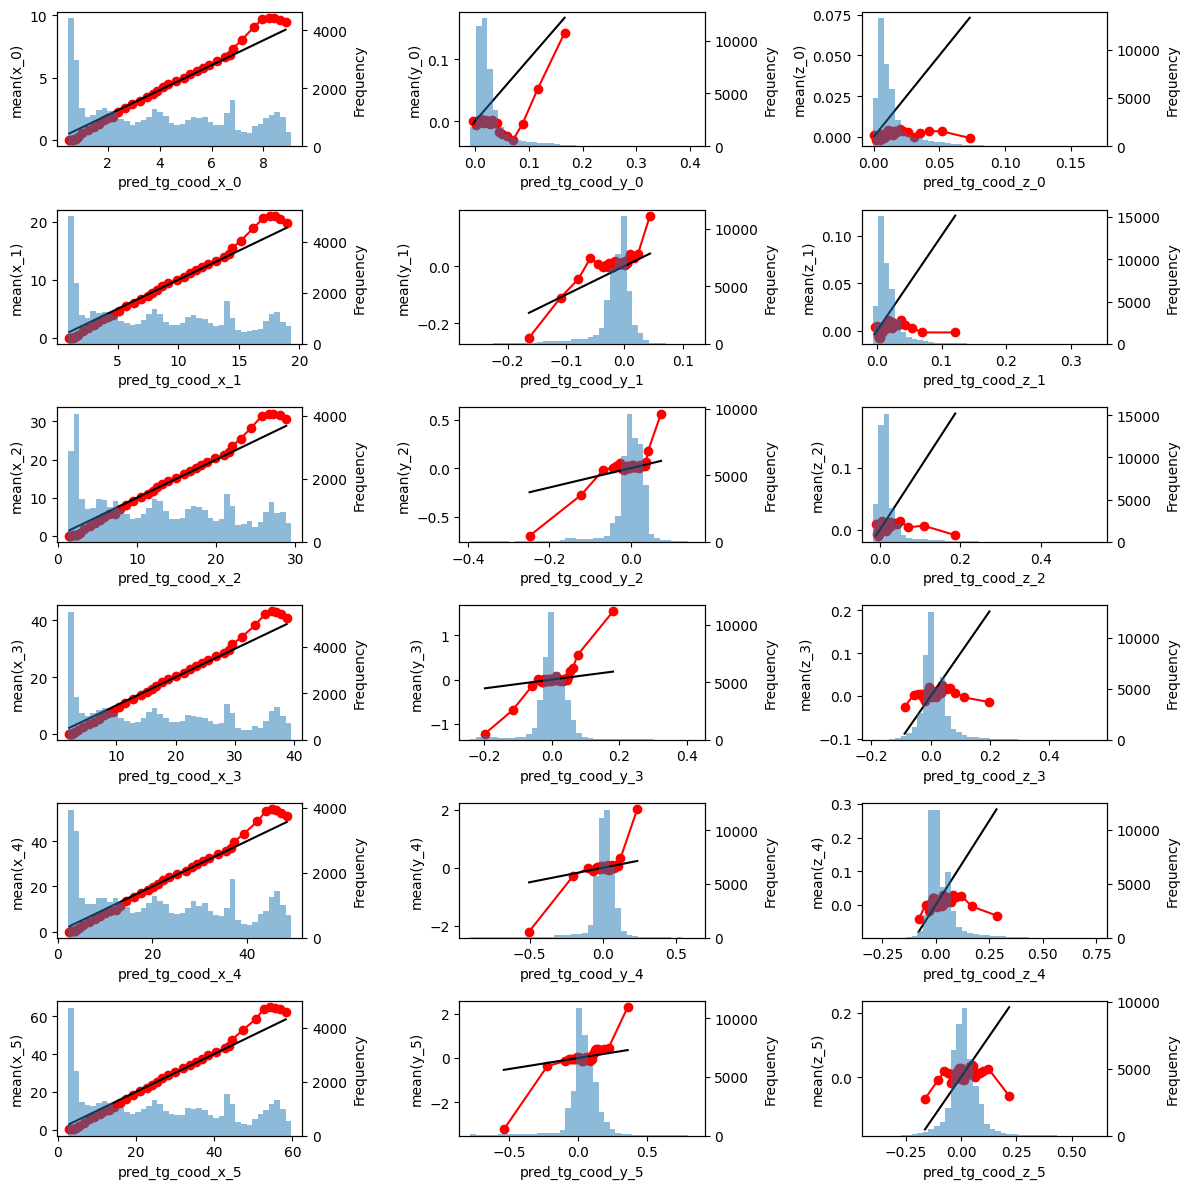

In [15]:
utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

## Submission

In [16]:
preds = utils.predict(models, ts_images, ts_df, feature.columns, pred_cols)
preds

pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.581362,0.00763,0.001736,3.32626,-0.021762,0.005023,5.043715,-0.020182,0.001307,6.915506,-0.021892,-0.006324,8.477461,-0.036444,0.006467,10.178864,-0.079259,0.004278
2.292623,0.165876,0.073928,4.800183,-0.176091,0.113711,7.940285,-0.164885,0.129751,10.168004,-0.08024,0.091045,13.27866,-0.232577,0.131211,15.608288,-0.158307,0.024611
1.720407,0.01046,0.002266,3.598348,-0.009008,0.006217,5.451695,-0.006237,0.002424,7.484436,-0.013297,-0.004636,9.268011,-0.019043,0.00513,11.03442,-0.051927,0.011564
1.716121,0.057373,0.018025,3.58432,-0.051937,0.021745,5.578766,-0.020713,0.038261,7.356333,0.022995,0.023092,9.36247,-0.031109,0.026815,10.923087,-0.00032,-0.00505
1.022682,0.008595,0.004934,2.14288,-0.025765,0.003887,3.351662,-0.025928,0.010366,4.504183,-0.016521,-0.003522,5.451249,-0.029864,-0.007923,6.668313,-0.039512,-0.019444
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6.552565,0.039838,0.023595,13.852954,-0.009083,0.041697,21.120945,0.004777,0.044968,28.414014,-0.008316,0.034516,35.812286,0.025109,0.072791,42.967314,0.074296,0.061027
6.833967,0.015133,0.01179,14.4175,0.001346,0.024783,22.002559,0.007255,0.029894,29.538835,0.000962,0.018458,37.218366,0.012328,0.037021,44.641824,0.01812,0.032635
7.05732,0.015354,0.010656,14.883016,0.002272,0.022423,22.703077,0.011575,0.024902,30.53294,0.012353,0.017966,38.503042,0.024232,0.030922,46.241168,0.025903,0.028838


In [17]:
def create_submission_csv(preds: pl.DataFrame, filename: str = "submission.csv"):
    submission_cols = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

    # validate preds columns
    if len(preds.columns) != len(submission_cols):
        raise ValueError(
            f"preds columns must be {len(submission_cols)}, but got {len(preds.columns)}"
        )

    preds.columns = submission_cols
    preds.write_csv(filename)
    print(f"Submission file is created: {filename}")


create_submission_csv(preds)

Submission file is created: submission.csv
